# Design and test a lowpass filter

Taking into consideration the engine's gear ratio of 7.5, an encoder resolution of 64, and the desired frequency for publishing angular velocity set at 50Hz, a range of ticks will be generated by the encoder during one timer cycle, varying from 7 ticks (at 5 rad/s) to 60 ticks (at 40 rad/s), for example. However, it is evident that 7 ticks are insufficient.

To address this issue, the problem is partially solved by employing a method that calculates angular velocity based on the time intervals between consecutive encoder ticks. This approach significantly improves the measurement accuracy of low velocities. Nonetheless, when dealing with high velocities, there is a need for a high-frequency noise filtering system. Therefore, the implementation of a low-pass filter is planned.

This document is part of a comparison between two potential solutions for filtering odometric data - a conventional low-pass filter and a Butterworth filter, and describes how to design a lowpass filter with a cutoff frequency $\omega_c$ and compute the discrete coefficients so that it can be implemented on hardware.

In [23]:
# Packages and adjustments to the figures
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = 10, 5
plt.rcParams["font.size"] = 16
plt.rcParams.update(
    {"text.usetex": True, "font.family": "sans-serif", "font.sans-serif": ["Helvetica"]}
)


def trim_data(data, start_time, end_time):
    trimmed_data = [[], []]
    for t, d in zip(data[0], data[1]):
        if t < start_time:
            continue
        elif t > end_time:
            break
        else:
            trimmed_data[0].append(t)
            trimmed_data[1].append(d)

    return trimmed_data


## 1. Generate a test signal

The power spectrum is plotted as the magnitude of the discrete fourier transform (DFT): $|\hat{\boldsymbol{y}}|$

Text(0, 0.5, '$|\\hat{y}|$')

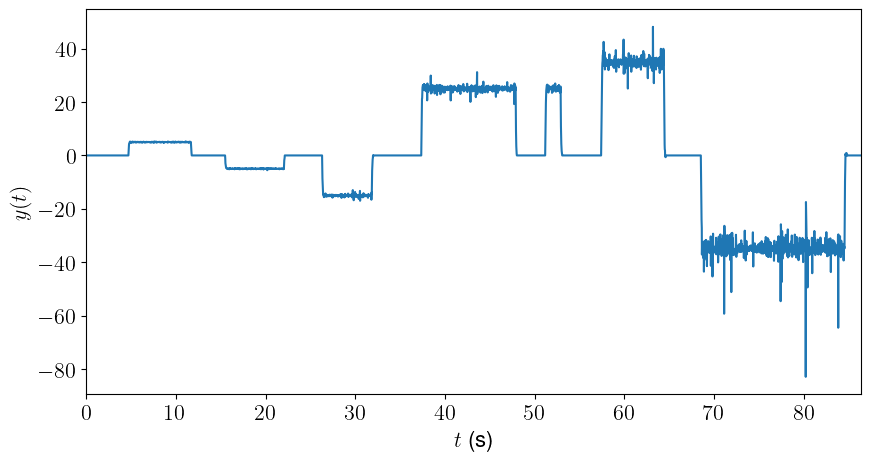

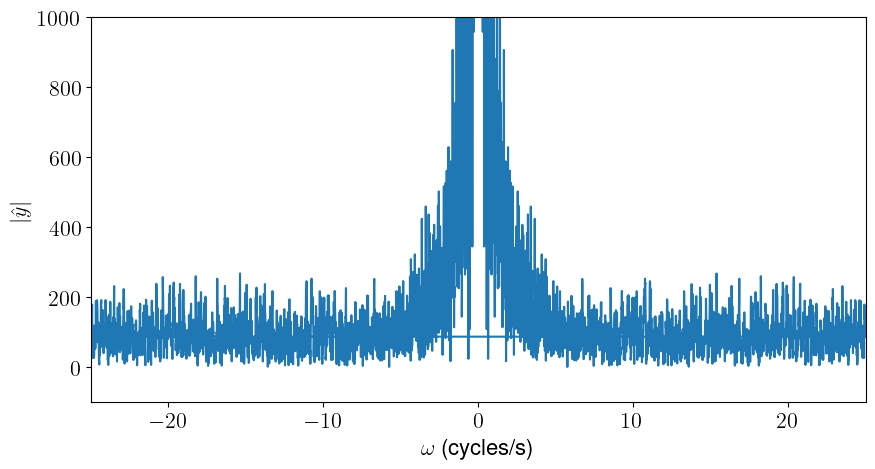

In [24]:
motor_name = 'right'
start_time = 0
end_time = 90

ang_vel = np.loadtxt(f"csv/{motor_name}_ang_vel.csv", delimiter=',')
ang_vel = trim_data(ang_vel, start_time, end_time)

t = ang_vel[0]
y = ang_vel[1]

dt = np.mean(np.diff(t))
sampling_freq = 1 / dt

# Compute the Fourier transform
yhat = np.fft.fft(y)
fcycles = np.fft.fftfreq(len(t), d=1.0 / sampling_freq)

# Plot the signal
plt.figure()
plt.plot(t, y)
plt.ylabel("$y(t)$")
plt.xlabel("$t$ (s)")
plt.xlim([min(t), max(t)])

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat))
plt.ylim([-100, 1000])   # to visualize better
plt.xlim([-sampling_freq / 2, sampling_freq / 2])
plt.xlabel("$\omega$ (cycles/s)")
plt.ylabel("$|\hat{y}|$")

## 2. Low-pass filter transfer function

* A cutoff frequency is selected and the transfer function for the low-pass filter is computed using <code>signal.TransferFunction</code>
* The low-pass filter transfer function is
$$H(s) = \frac{\omega_0}{s + \omega_0}$$
* The Bode plot shows the frequency response of $H$ by plotting the magnitude and phase of the frequency response
* Low frequencies are not attenuated (this is the *pass band*)
* High frequencies are attenutated (this is the *stop band*)


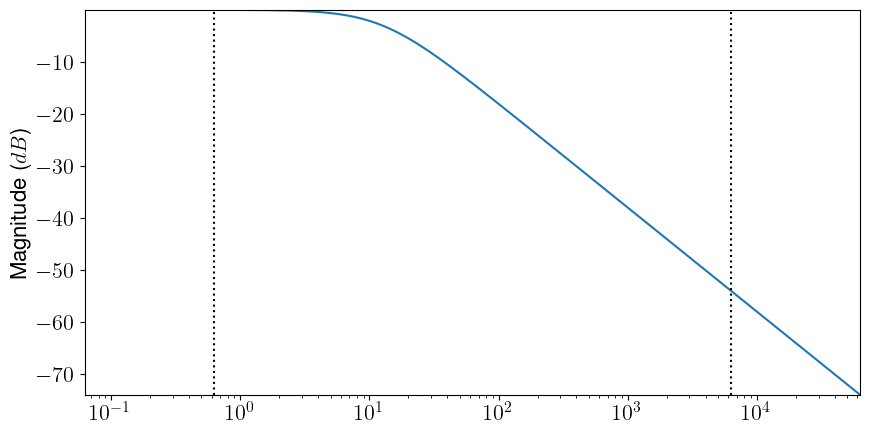

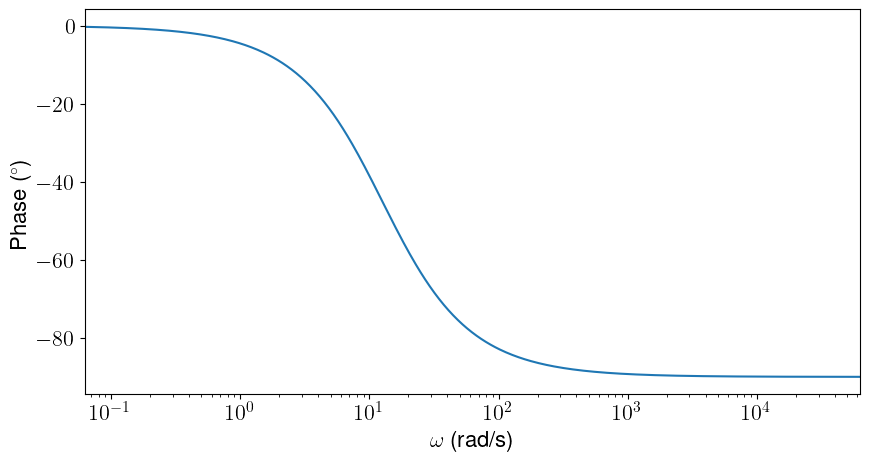

In [25]:
signal_freq = [0.1, 1000]  # min, max
w0 = 2 * np.pi * 2
# pole frequency (rad/s)
num = w0
den = [1, w0]
low_pass = signal.TransferFunction(num, den)

# Generate the bode plot
w = np.logspace(
    np.log10(min(signal_freq) * 2 * np.pi / 10), np.log10(max(signal_freq) * 2 * np.pi * 10), 500
)
w, mag, phase = signal.bode(low_pass, w)

# Magnitude plot
plt.figure()
plt.semilogx(w, mag)
for sf in signal_freq:
    plt.semilogx([sf * 2 * np.pi, sf * 2 * np.pi], [min(mag), max(mag)], 'k:')
plt.ylabel("Magnitude ($dB$)")
plt.xlim([min(w), max(w)])
plt.ylim([min(mag), max(mag)])

# Phase plot
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.ylabel("Phase ($^\circ$)")
plt.xlabel("$\omega$ (rad/s)")
plt.xlim([min(w), max(w)])
plt.show()


## 3. Discrete transfer function

To implement the low-pass filter on hardware, you need to compute the discrete transfer function using the signal's sampling frequency.
* The time step is $\Delta t = 1/f_s$
* Computing the discrete transfer function using Tustin's method, set $s = \frac{2}{\Delta t} \left( \frac{1-z^{-1}}{1+z^{-1}} \right)$, so
$$ H(z) = \frac{\omega_0}{\frac{2}{\Delta t} \frac{1-z^{-1}}{1+z^{-1}}  + \omega_0} = \frac{\Delta t \omega_0 (z+1)}{(\Delta t \omega_0 + 2)z + \Delta t \omega_0 - 2} $$
* You don't have to compute it by hand. The <code>to_discrete</code> method is used to compute the bilinear transform (Tustin's method)

In [26]:
discrete_low_pass = low_pass.to_discrete(dt, method='gbt', alpha=0.5)
print(discrete_low_pass)

TransferFunctionDiscrete(
array([0.1116292, 0.1116292]),
array([ 1.       , -0.7767416]),
dt: 0.01999878745451949
)


## 4. Filter coefficients

We want to find the filter coefficients for the discrete update:
$$y[n] = a_1 y[n-1] + a_2 y[n-2] + ... + b_0 x[n] + b_1 x[n-1] + ...$$

The coefficients can be taken directly from the discrete transfer function of the filter in the form:
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2} + \ldots}{1 - a_1 z^{-1} - a_2 z^{-2} + \ldots}$$

(This is a result of taking the Z-transform which is not shown here)

Compare this to a transfer function with coefficients
<code>
num = [b_0, b_1, b_2]
den = [1, a_1, a_2]
</code>
is 
$$H(z) = \frac{b_0 z^2 + b_1 z + b_2}{z^2 + a_1 z + a_2}$$
which is equivalent to
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 + a_1 z^{-1} + a_2 z^{-2}}$$
So you can take the coefficients in the same order that they are defined in the numerator and denominator of the transfer function object. The only difference is that the **coefficients in the denominator need a negative sign**.

* To filter the signal, apply the filter using the discrete update
* The filtered signal and filtered signal power spectrum are plotted alongside the unfiltered signal

Filter coefficients b_i: [0.1116292 0.1116292]
Filter coefficients a_i: [0.7767416]


Text(0, 0.5, '$|\\hat{y}|$')

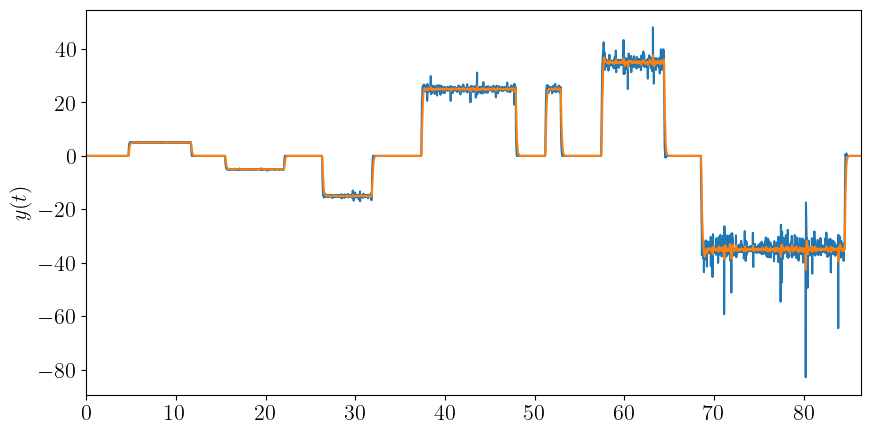

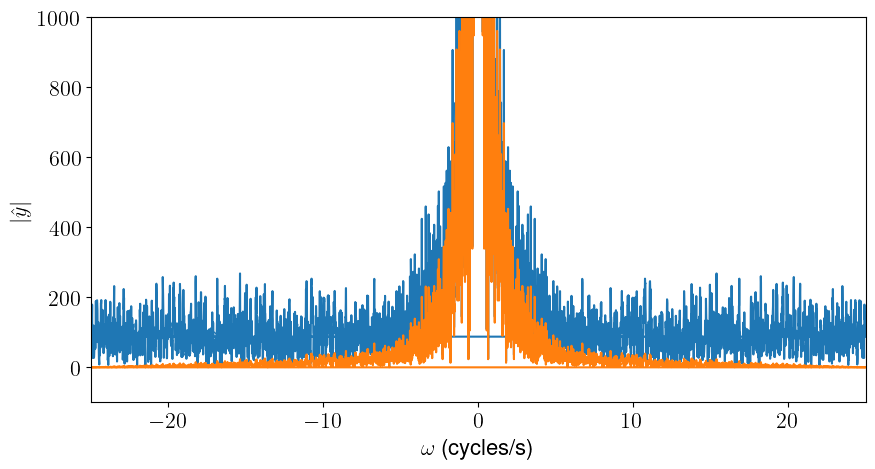

In [27]:
# The coefficients from the discrete form of the filter transfer function (but with a negative sign)
b = discrete_low_pass.num
a = -discrete_low_pass.den
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

# Filter the signal
yfilt = np.zeros(len(y))
for i in range(3, len(y)):
    yfilt[i] = a[1] * yfilt[i-1] + b[0] * y[i] + b[1] * y[i-1]
    
# Plot the signal
plt.figure()
plt.plot(t, y)
plt.plot(t, yfilt)
plt.ylabel("$y(t)$")
plt.xlim([min(t), max(t)])

# Generate Fourier transform
yfilthat = np.fft.fft(yfilt)
fcycles = np.fft.fftfreq(len(t), d=dt)

plt.figure()
plt.plot(fcycles,np.absolute(yhat))
plt.plot(fcycles,np.absolute(yfilthat))
plt.xlim([-sampling_freq / 2, sampling_freq / 2])
plt.ylim([-100, 1000])
plt.xlabel("$\omega$ (cycles/s)")
plt.ylabel("$|\hat{y}|$")
